# Pharmaceutical Sales prediction across multiple stores


- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Empirical Cumulative Distribution Function](#Empirical-Cumulative-Distribution-Function)
    - [Filtering Missing Values](#Filtering-Missing-Values)
    - [Store data Analysis](#Store-data-Analysis)
    - [Correlation Analysis](#Correlation-Analysis)
    - [Checking for Seasonality](#Checking-for-Seasonality)
    - [Competitor Distance](#Competitor-Distance)
    - [Open Competition Since](#Open-Competition-Since)
- [Model Building And Prediction](#Model-Building-And-Prediction)
    - [Preprocessing](#preprocessing)
    - [Model Building](#Model-Building)
    - [Prediction](#Prediction)
    - [Serializing The Model](#Serializing-The-Model)
    - [Time Series Prediction](#Time-Series-Prediction)
    - [Prediction Analysis](#Prediction-Analysis)

## Exploratory Data Analysis

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [125]:
dfTrain = pd.read_csv('train.csv', low_memory=False, parse_dates=True, index_col='Date')
dfTest = pd.read_csv('test.csv', low_memory=False, parse_dates=True, index_col='Date')
dfStore = pd.read_csv("store.csv", low_memory=False)
print("The Training set's shape is: ", dfTrain.shape)
dfTrain.head()

The Training set's shape is:  (1017209, 8)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [51]:
dfTrain.StateHoliday.unique()

array(['0', 'a', 'b', 'c'], dtype=object)

In [52]:
dfTrain.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

In [126]:
# add aditional columns to the dataset. 
def dataTuning(df):
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    df['WeekOfYear'] = df.index.weekofyear
    
    return df

dfTrain = dataTuning(dfTrain)
dfTrain['SalePerCustomer'] = dfTrain['Sales']/dfTrain['Customers']
dfTrain['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

On average the users spend about 9.5 dollars but there are days with 0 sales and some with up to approximately 65 dollars

### Empirical Cumulative Distribution Function

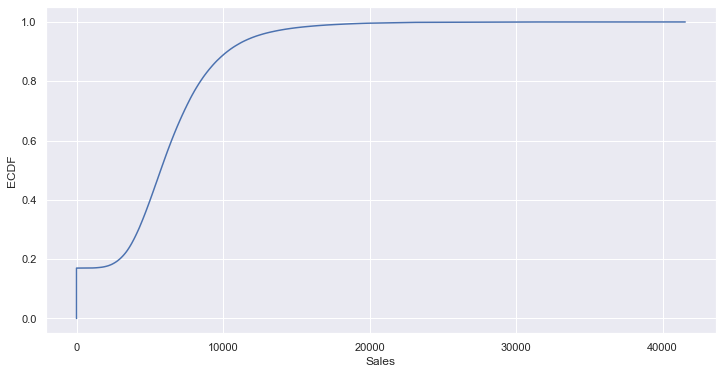

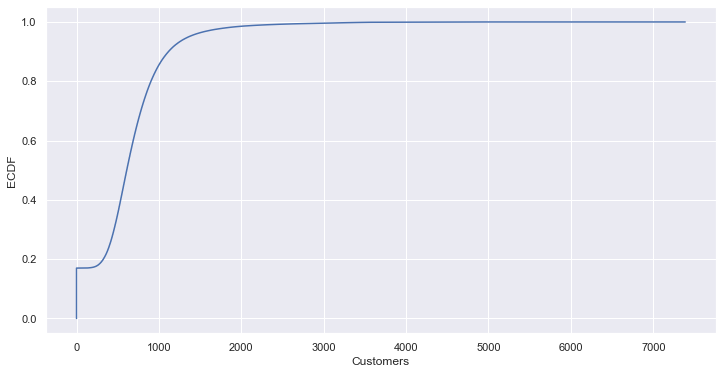

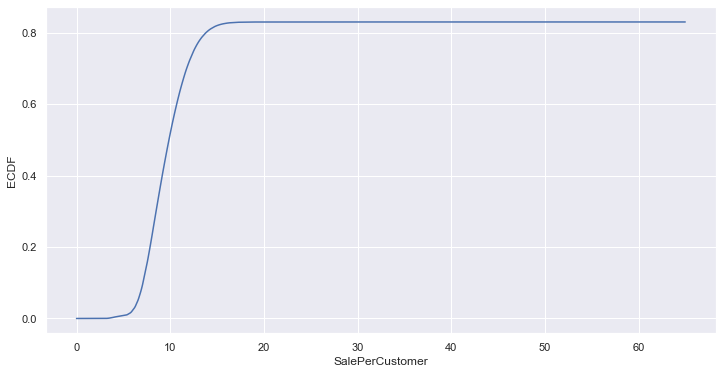

In [6]:
from statsmodels.distributions.empirical_distribution import ECDF

# this fucntion plots the empirical cumulative distribution
def ecdfPlot(series):
    plt.figure(figsize = (12, 6))
    cdf = ECDF(series)
    plt.plot(cdf.x, cdf.y, label="statmodels")
    plt.xlabel(series.name); plt.ylabel('ECDF')
    

ecdfPlot(dfTrain['Sales'])
ecdfPlot(dfTrain['Customers'])
ecdfPlot(dfTrain['SalePerCustomer'])

From the first two graphs we can tell that about 20% of the data has 0 amount os sales and customers.Could this be due to closed stores?

### Filtering Missing Values

In [127]:
# finding the closed stores
dfTrain[(dfTrain.Open == 0) & (dfTrain.Sales == 0)].shape


(172817, 12)

In [128]:
# finding opened stores with zero sales
zeroSales = dfTrain[(dfTrain.Open != 0) & (dfTrain.Sales == 0)]
zeroSales.shape

(54, 12)

We drop the stores with zero no sales and the closed as they make up only a small percentage of our dataset (about 17%)

In [129]:
# dropping the zero sales and closed stores
dfTrain = dfTrain[(dfTrain.Open != 0) & (dfTrain.Sales != 0)]
dfTrain.shape

(844338, 12)

In [103]:
# Showing the store data
print("The store dataset shape is: ", dfStore.shape)
dfStore.head()

The store dataset shape is:  (1115, 10)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [130]:
# finding the missing values in the store dataset
dfStore.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [131]:
# starting with the CompetitionDistance column
dfStore[pd.isnull(dfStore.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [132]:
# filling the NaN values in CompetitionDistance col
dfStore.CompetitionDistance.fillna(dfStore.CompetitionDistance.median(), inplace=True)

In [133]:
# replace all the other NaN values with zeros
dfStore.fillna(0, inplace=True)
dfStore.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [14]:
# merge the Store data and the train data
def merge(df, store):
    dfJoined = pd.merge(df, store, how='inner', on='Store')
    return dfJoined

In [134]:
dfTrainStore = merge(dfTrain, dfStore)
print("The shape of the merged training and store dataset is: ", dfTrainStore.shape)
dfTrainStore.head()

The shape of the merged training and store dataset is:  (844338, 21)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


### Store data Analysis

In [16]:
# get the statistics of each Store Type
dfTrainStore.groupby('StoreType').Sales.describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


In [17]:
# GEt the total sum of Sales and Customers for each store type
dfTrainStore.groupby('StoreType')['Customers', 'Sales'].sum()

c:\users\gkkar\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


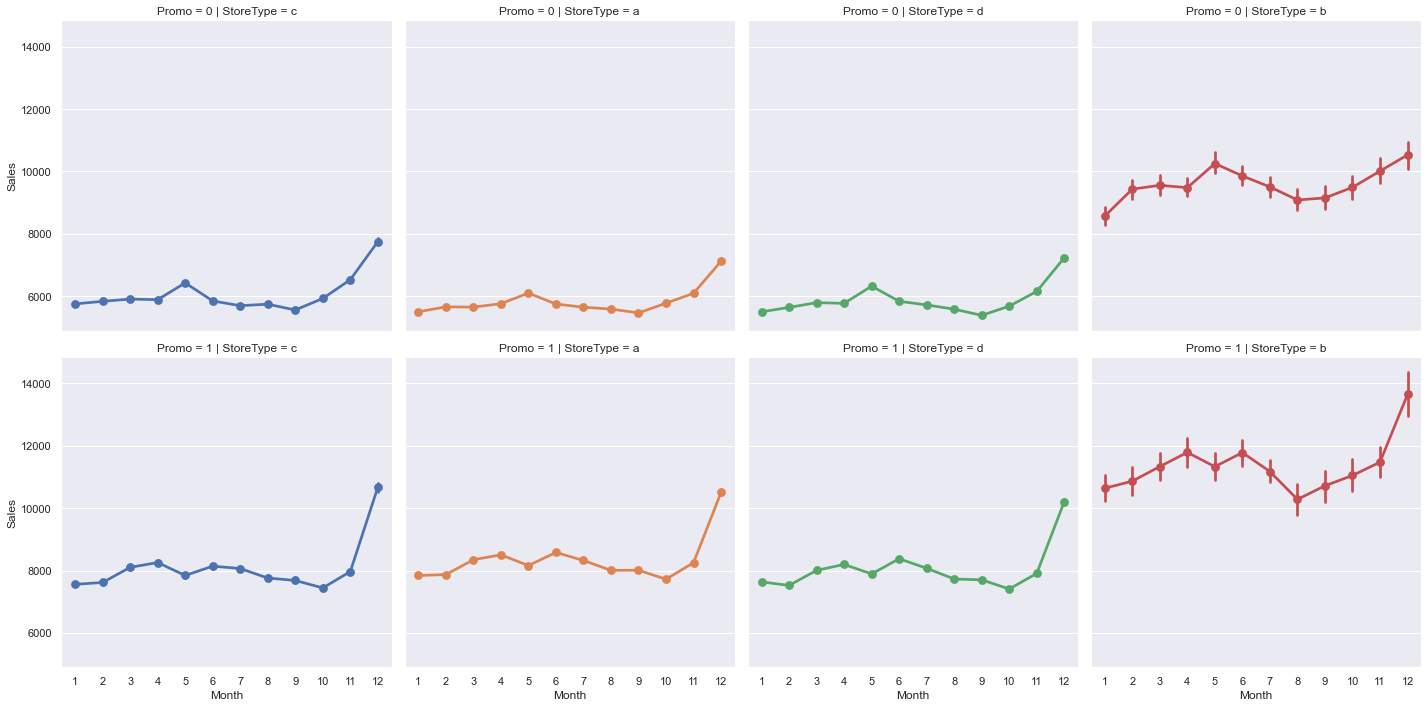

In [18]:
# ploting the Monthly Sales for each store type when with a promo and without one
sns.catplot(x='Month', y='Sales', data=dfTrainStore, kind='point',
            col='StoreType', row='Promo', hue='StoreType')

- There is generally an increase in sales across all store types when there is a promo, with Store Type b having the most Sales through out the year.
- There is an increase in sales around christmas time (Month 12)

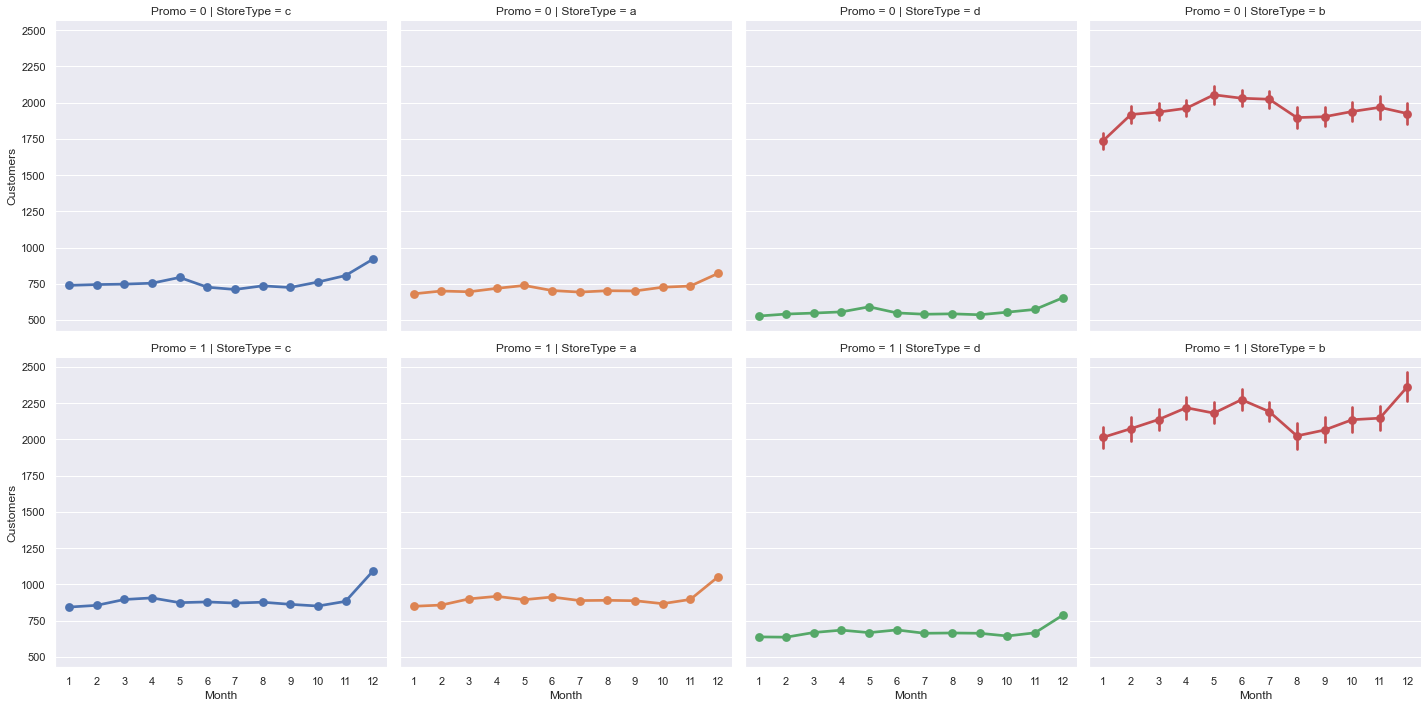

In [19]:
# ploting the montly data of the number Customers when there is a promo and when there isn't one
sns.catplot(y='Customers', x='Month', data=dfTrainStore, kind='point',
            col='StoreType', row='Promo', hue='StoreType')

- There is generally an increase in the number of customers across all store types when there is a promo, with Store Type b having the most Customers through out the year.
- There is an increase in the number of customers around christmas time (Month 12)

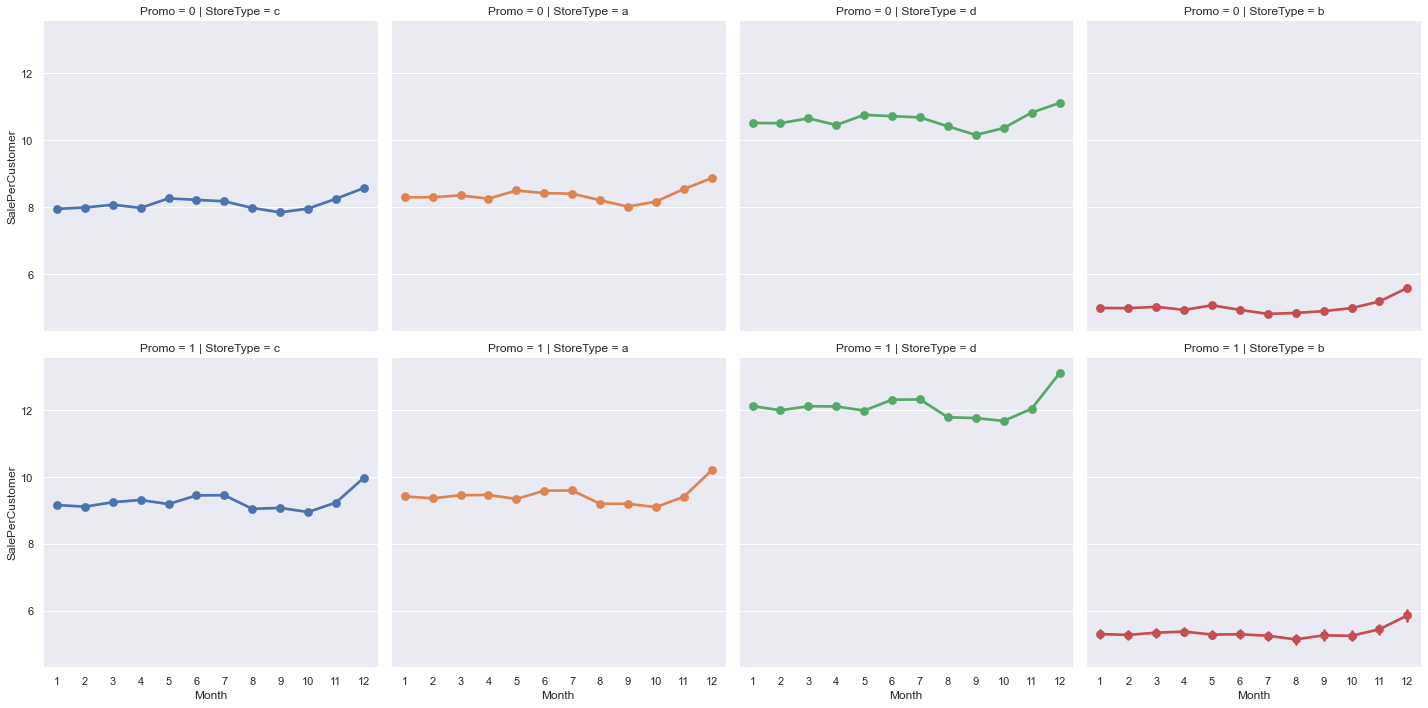

In [20]:
# ploting the montly data of the Sale per Customers when there is a promo 1 and when there isn't one
sns.catplot(y='SalePerCustomer', x='Month', data=dfTrainStore, kind='point',
            col='StoreType', row='Promo', hue='StoreType')

- When there is a promo the average money spent per customer also increases
- StoreType b has the lowest sales per customer i.e the store sells low cost items
- sStoreType d has the highest sales per customer i.e the store sells high cost items

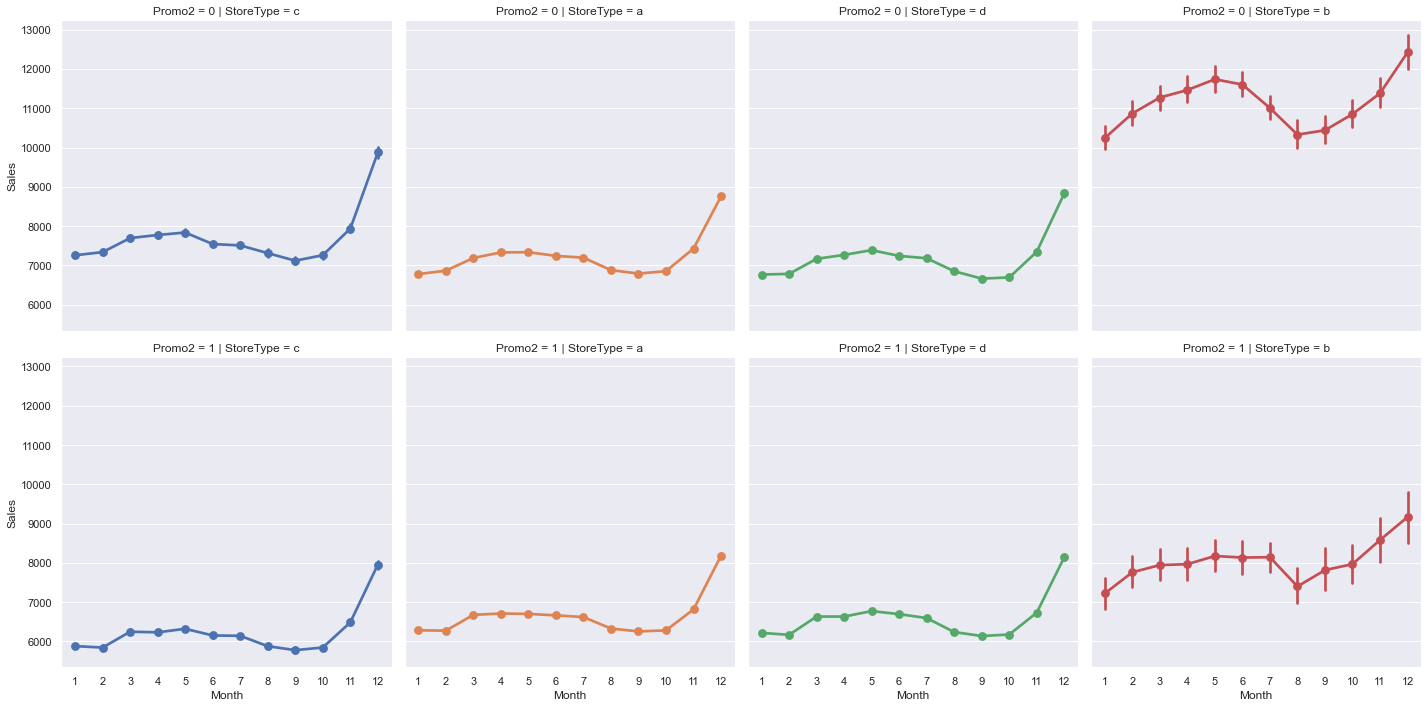

In [21]:
# ploting the montly data of the Sale per Customers when there is a promo 2 and when there isn't one
sns.catplot(y='Sales', x='Month', data=dfTrainStore, kind='point',
            col='StoreType', row='Promo2', hue='StoreType')

The promo2 is not as successful as the first one and a drop of sales is seen across all stores

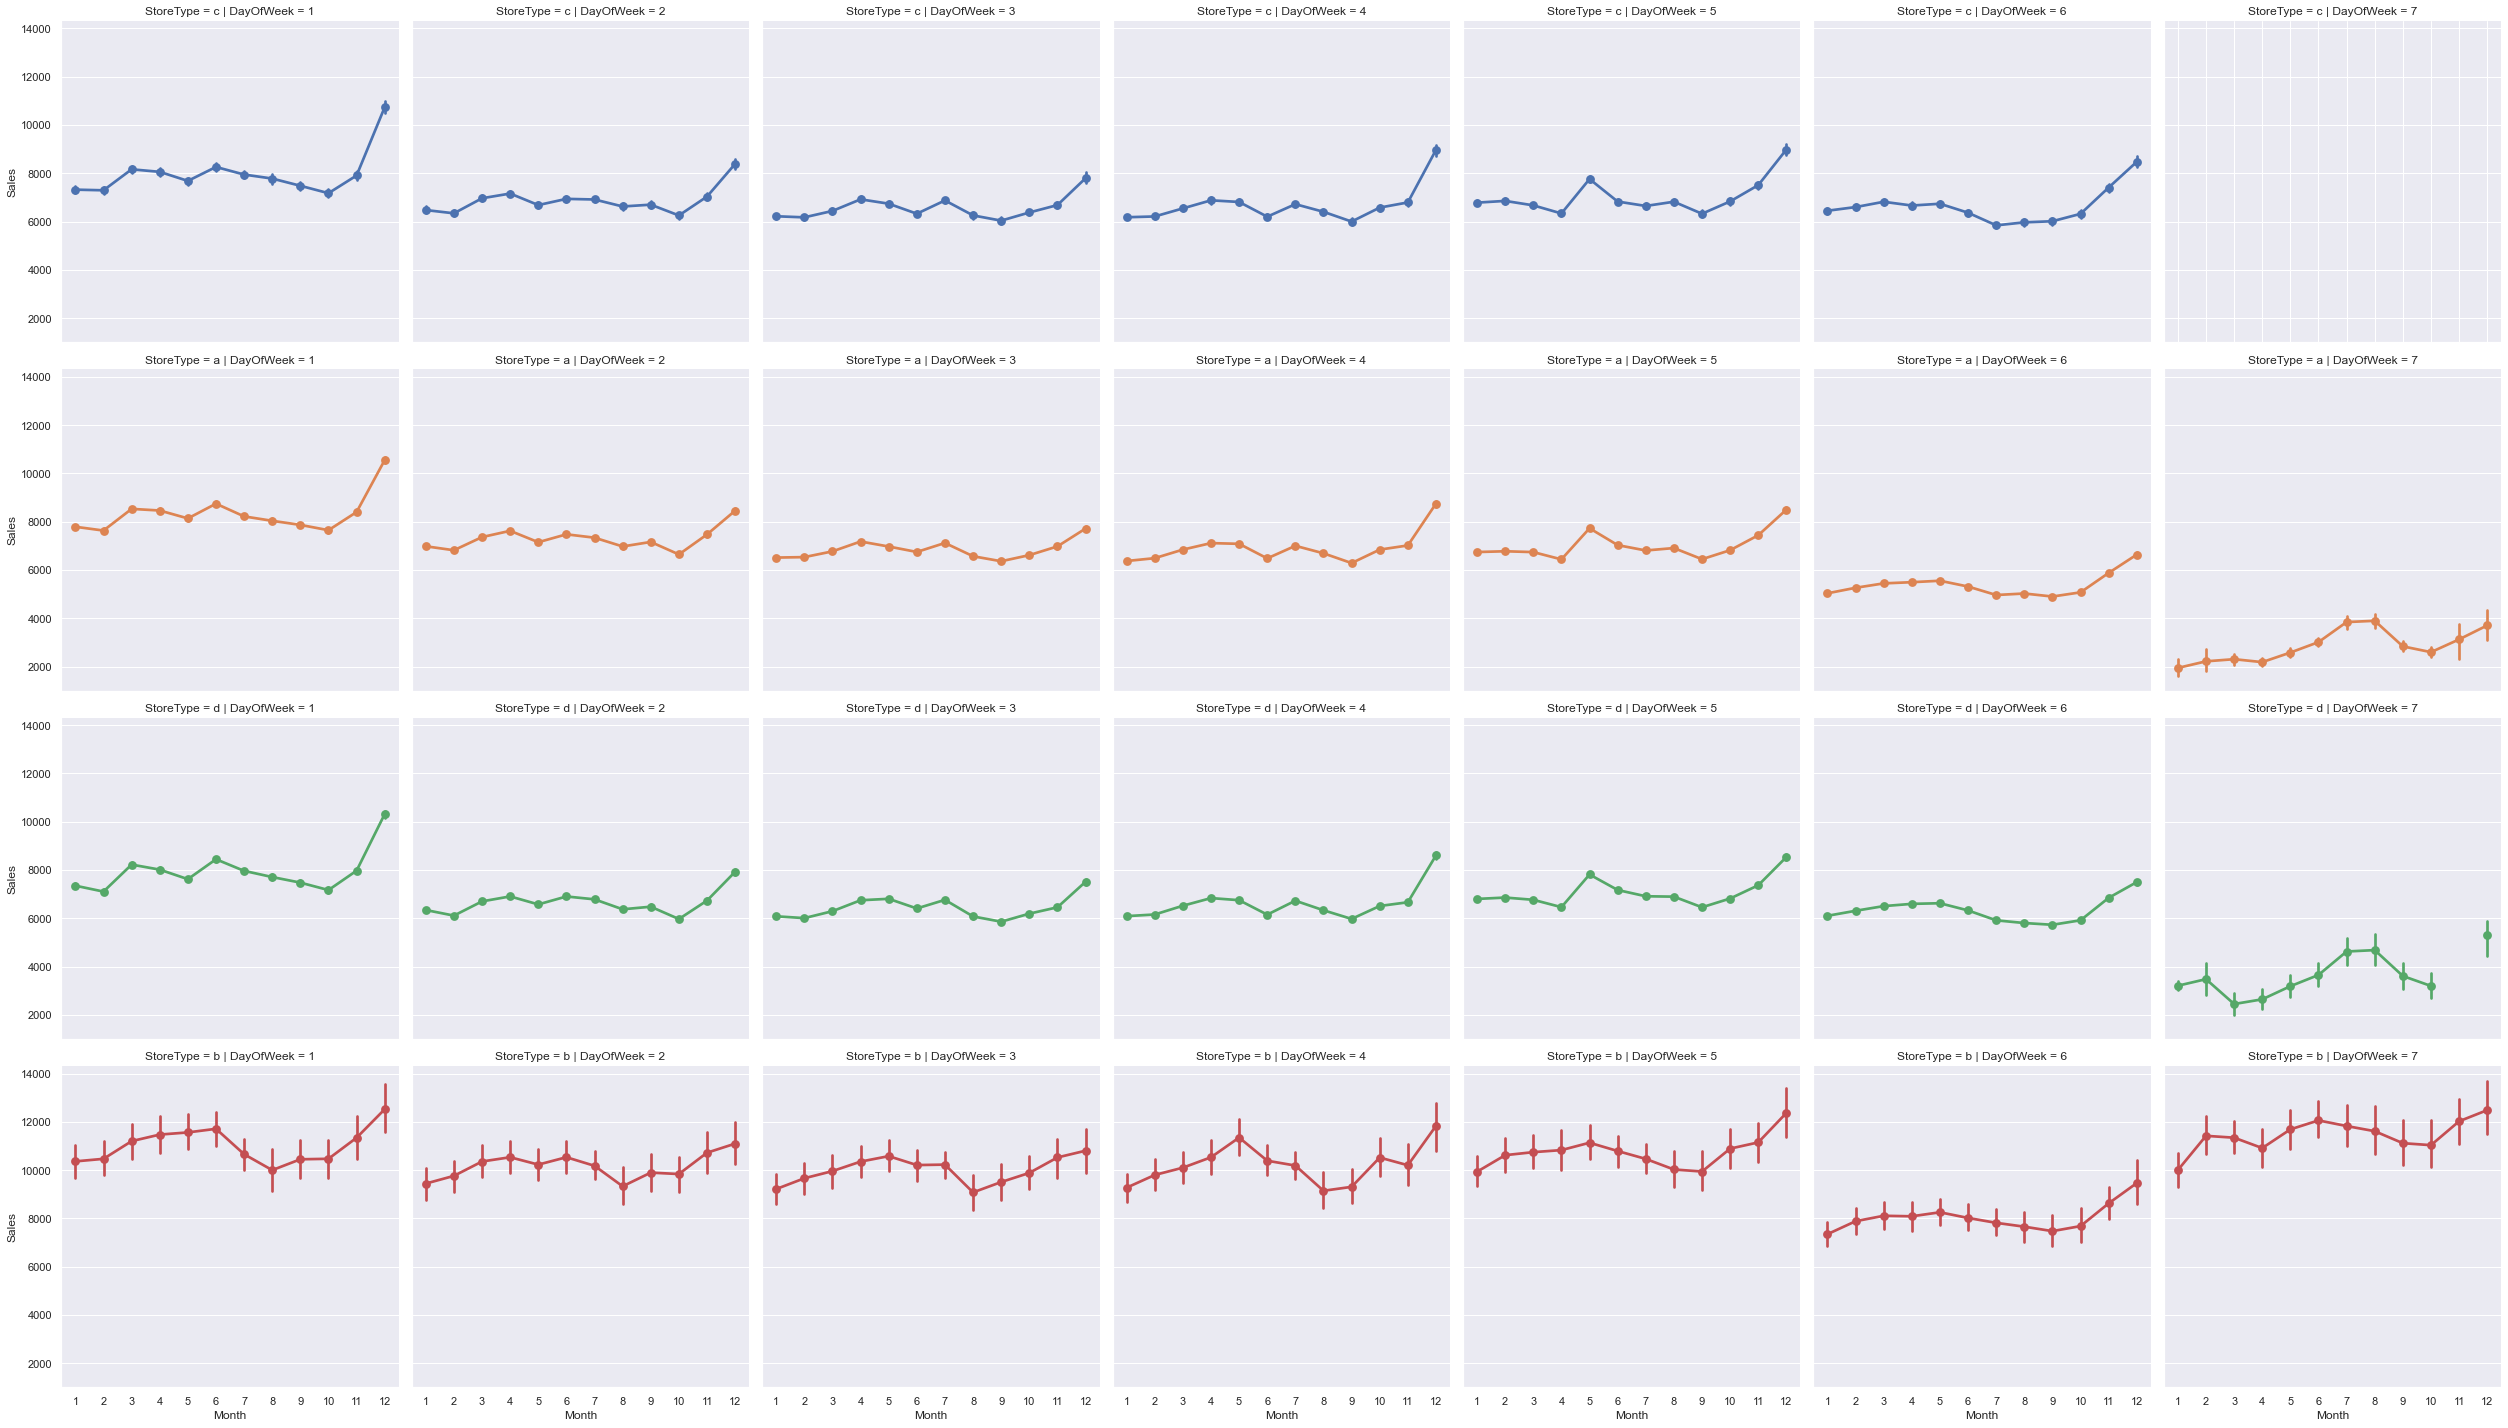

In [22]:
# ploting the daily data of the Sales for each type of Store Type
sns.catplot(x='Month', y='Sales', data=dfTrainStore, kind='point', 
            col='DayOfWeek', hue='StoreType', row='StoreType')

(Double click to zoom)
- Store Type C is closed on sundays all year Long
- Store Type D is closed on sundays for only two months October and November

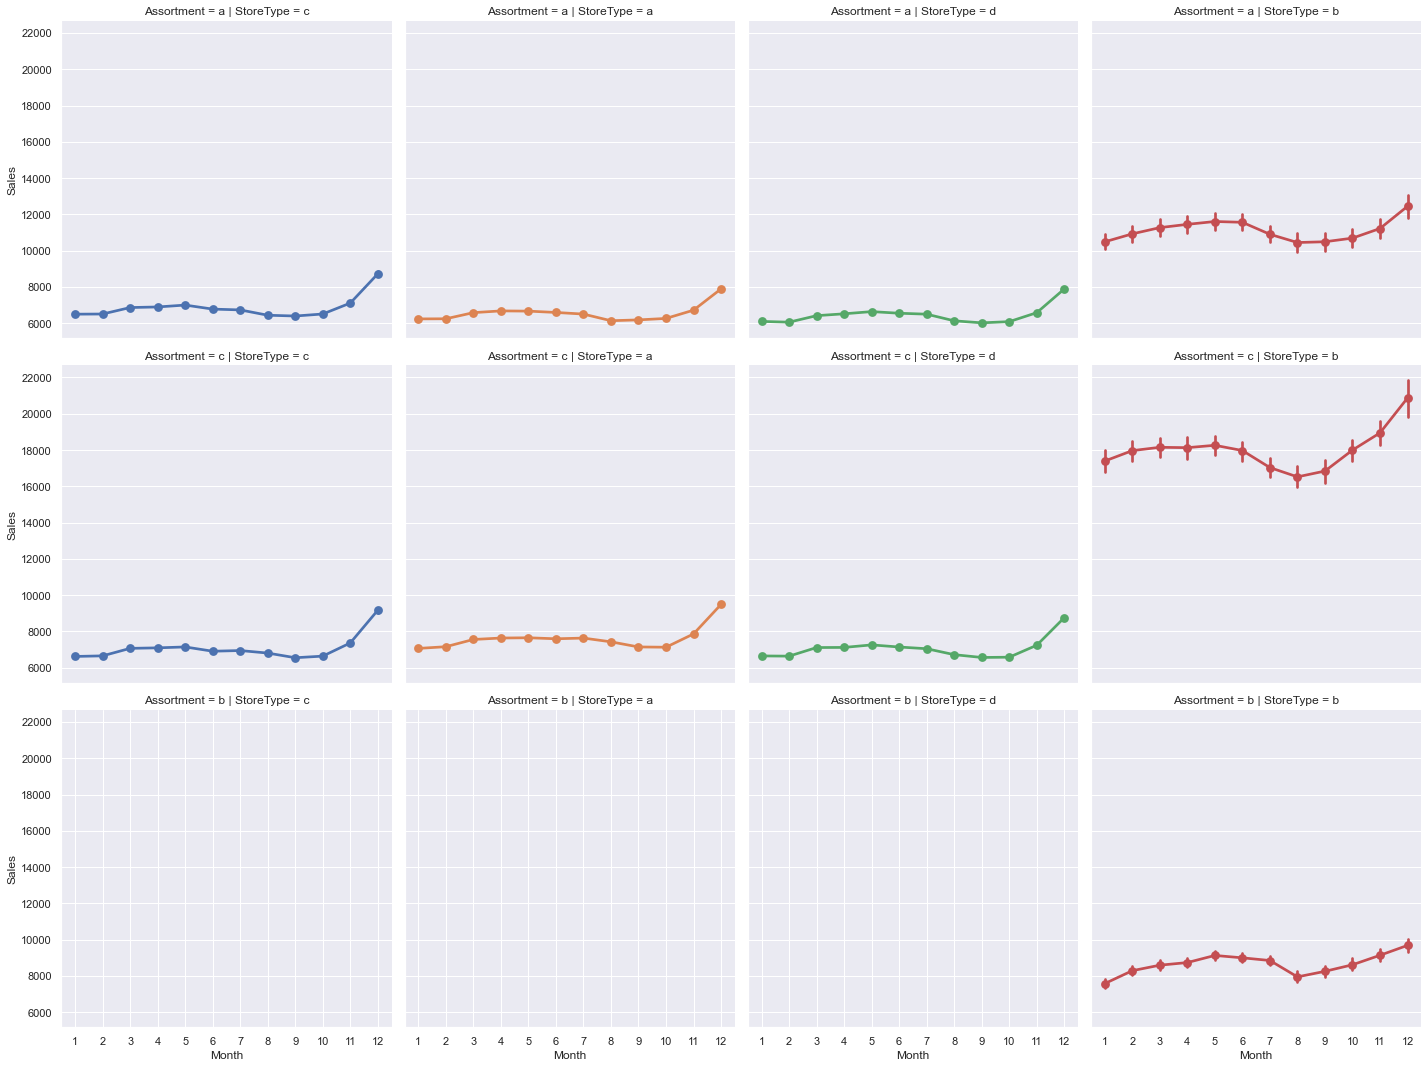

In [23]:
# How assorment type affects sales 
sns.catplot(x='Month', y='Sales', data=dfTrainStore, kind='point',
            col='StoreType', hue='StoreType', row='Assortment')


- The assortment c slightly increases the number of sales in the store types a, c and d in comparison to assortment a
- However assortment c offers a significant increase in store type b than assortment a and b

### Correlation Analysis


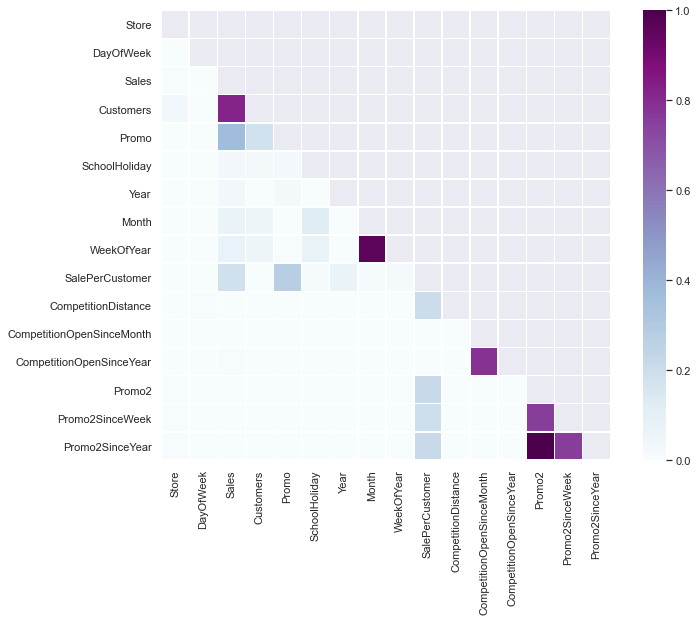

In [24]:
# get the correlation matrix
# dropping the open column
corr = dfTrainStore.drop('Open', axis=1).corr()

# create a mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# plot the correlation heatmap
sns.heatmap(corr, vmin=0, vmax=1, square=True, cmap="BuPu",
           linewidths=.5, mask=mask, fmt='.2f')

The Customer and Sales columns are highly coorelated as expected

### Checking for Seasonality

In [25]:
# Get the Sales data
timeSeries = dfTrain['Sales']
timeSeries.head()

Date
2015-07-31     5263
2015-07-31     6064
2015-07-31     8314
2015-07-31    13995
2015-07-31     4822
Name: Sales, dtype: int64

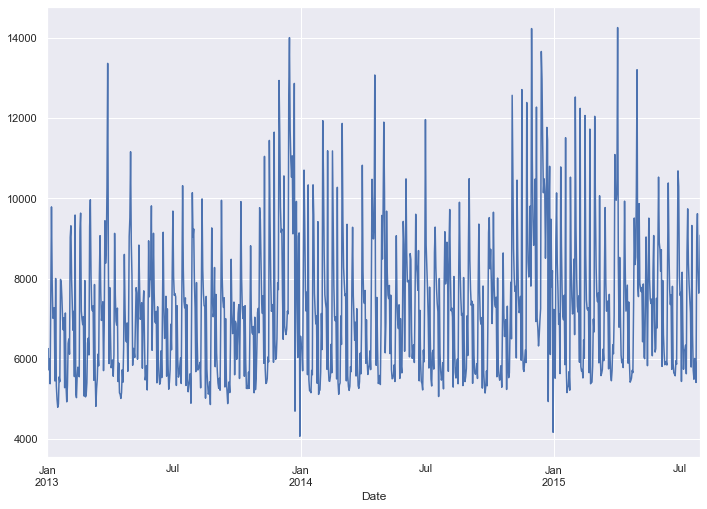

In [26]:
# plotting the mean sales values per day
timeSeriesDay = timeSeries.resample('D').mean()
timeSeriesDay.plot()

From the time series graph above we can see Just before January and in the middle of  January and July (probably around April)

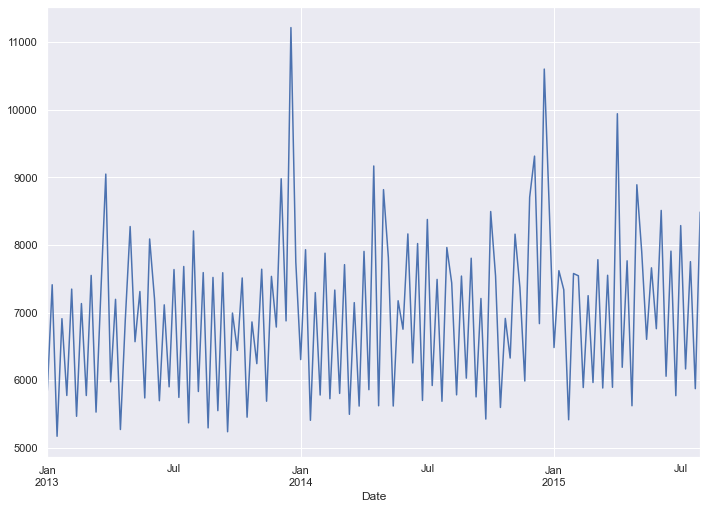

In [27]:
# plotting the mean sales values per week
timeSeriesWeek = timeSeries.resample('W').mean()
timeSeriesWeek.plot()

As we go from days to weeks the spikes mentioned above are more clear

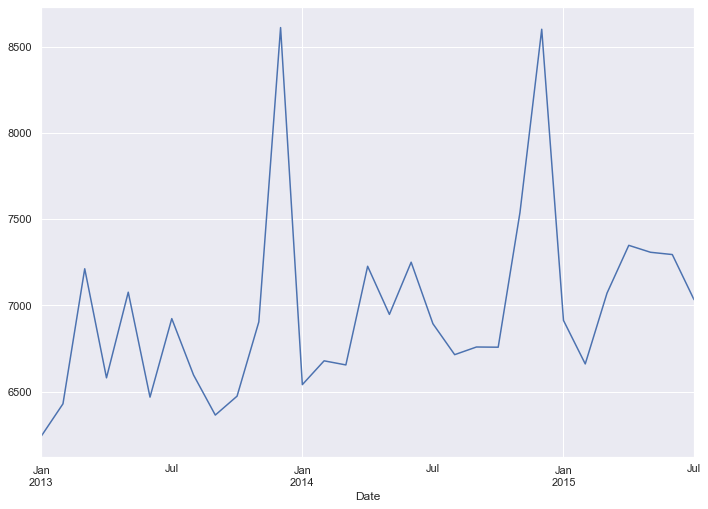

In [28]:
# plotting the mean sales values per Month
timeSeriesMonth = timeSeries.resample('M').mean()
timeSeriesMonth.plot()

The monthly data shows that the December spikes are the most apparent..

### Competitor Distance

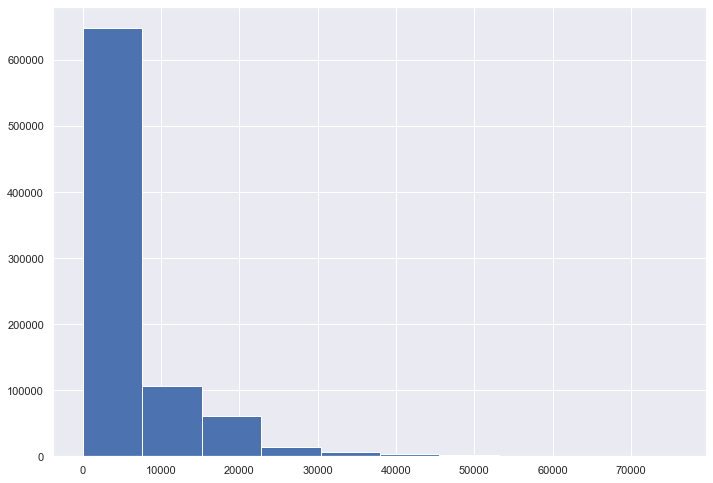

In [29]:
dfTrainStore.CompetitionDistance.hist()

In [135]:
# divide the data into distance ranges
distanceGroups = [dfTrainStore.CompetitionDistance.between(1, 99), dfTrainStore.CompetitionDistance.between(100, 999),
                  dfTrainStore.CompetitionDistance.between(1000, 9999), dfTrainStore.CompetitionDistance.between(10000, 99999)]
values = [1, 2, 3, 4]

dfTrainStore['DistanceGroup'] = np.select(distanceGroups, values, 0)
dfTrainStore.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DistanceGroup
0,1,5,5263,555,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,3
1,1,4,5020,546,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,3
2,1,3,4782,523,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,3
3,1,2,5011,560,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,3
4,1,1,6102,612,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,3


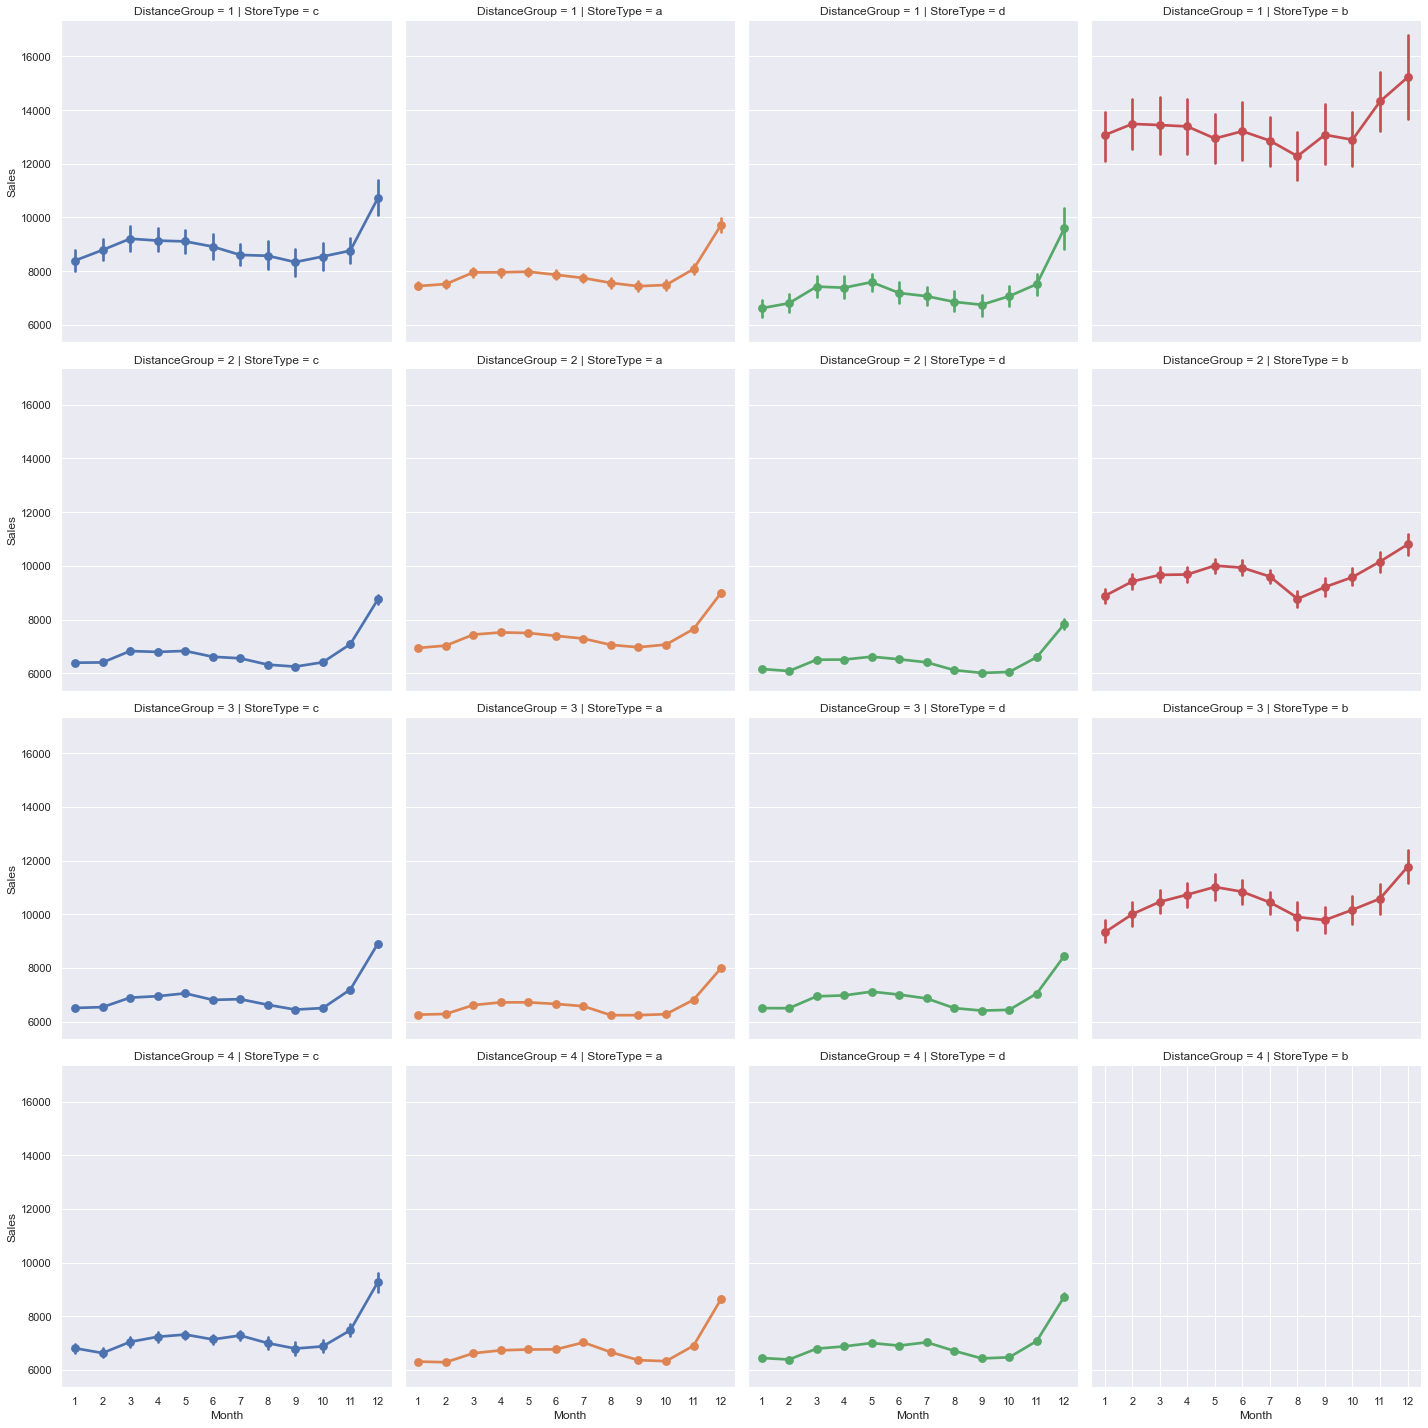

In [31]:
# plotting the monthly sales data for each of the distancegroups defined above
sns.catplot(y='Sales', x='Month', kind='point', hue='StoreType',
            col='StoreType', row='DistanceGroup', data=dfTrainStore)

### Open Competition Since

In [32]:
# Getting the unique values for each month the competition has been open
dfTrainStore.CompetitionOpenSinceMonth.unique()

array([ 9., 11., 12.,  4., 10.,  8.,  0.,  3.,  6.,  5.,  1.,  2.,  7.])

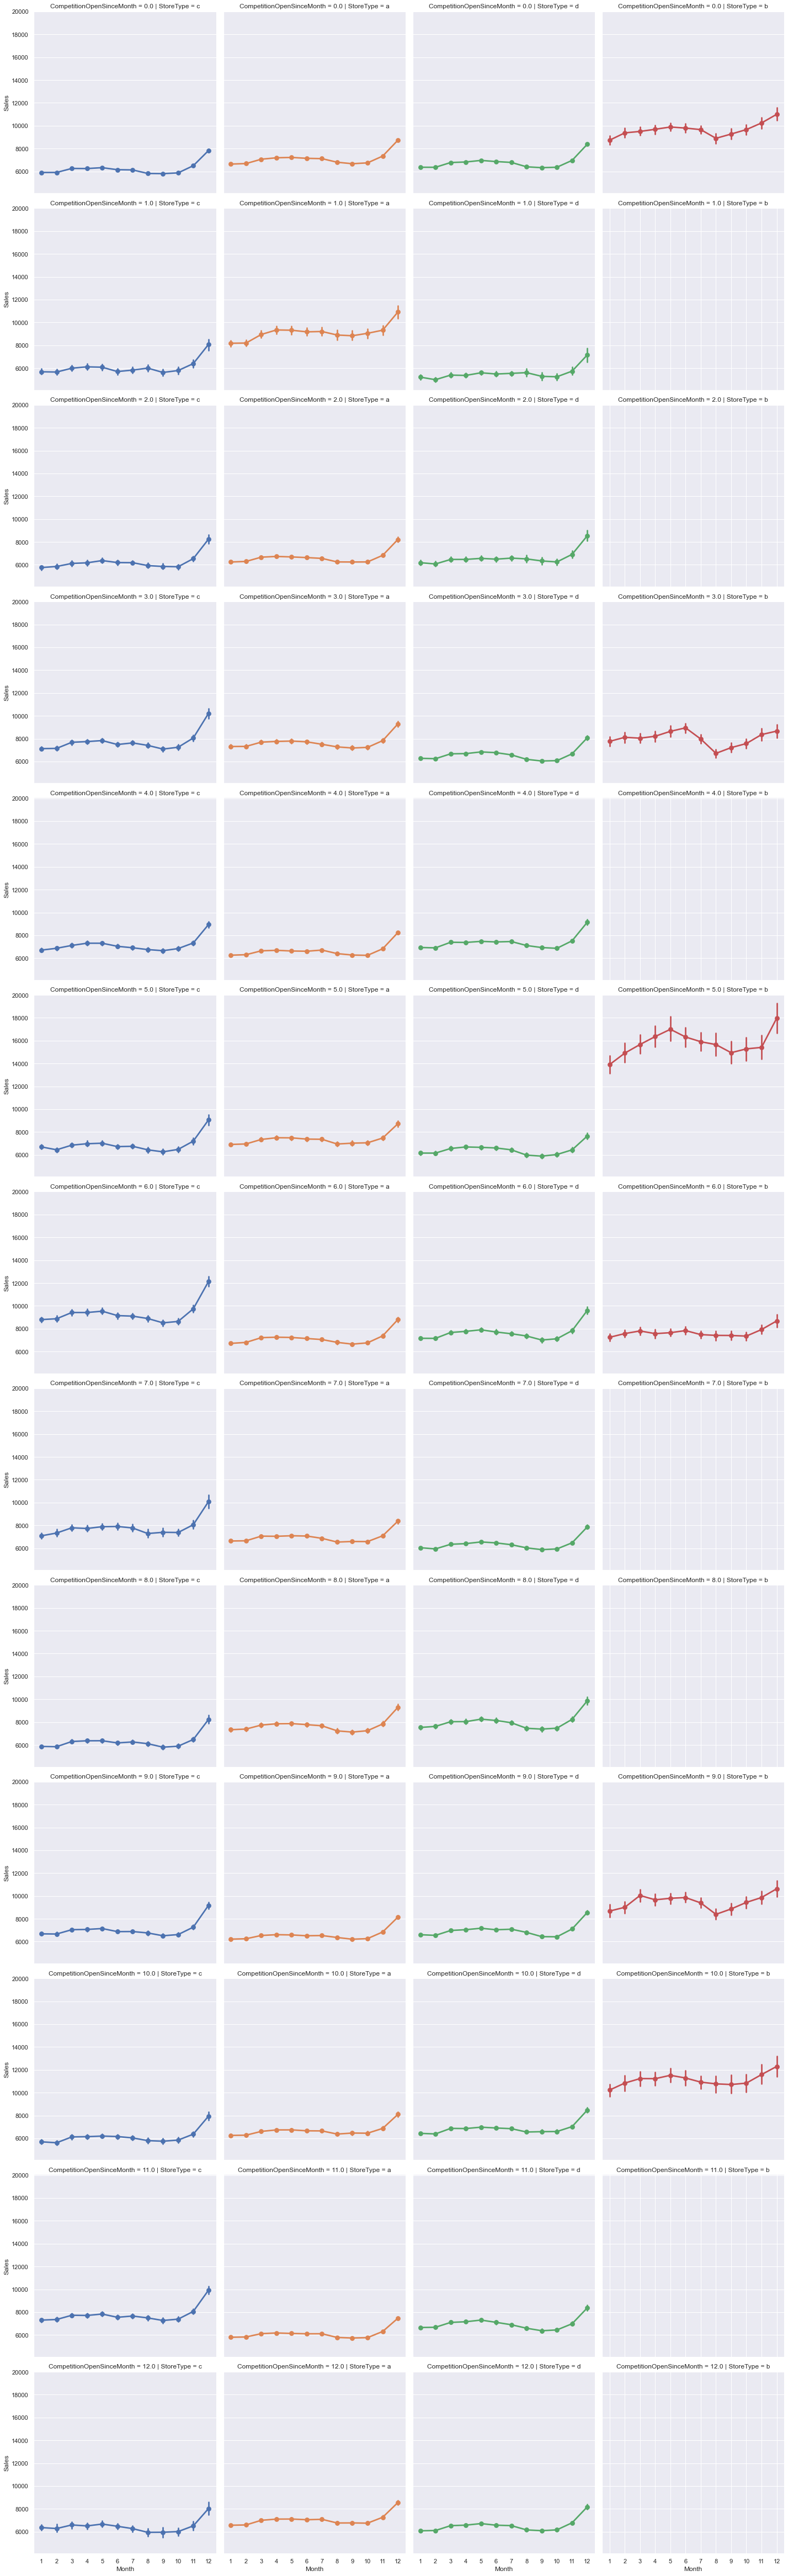

In [33]:
# plotting the monthly sales data for each of the months that the competition has been opened
sns.catplot(y='Sales', x='Month', kind='point', hue='StoreType',
            col='StoreType', row='CompetitionOpenSinceMonth', data=dfTrainStore)

In [136]:
# creates a new column that combines the CompetitionOpenSinceMonth and CompetitionOpenSinceYear columns
def compeSince(df):
    df['CompetitionOpenSince'] = np.where((df['CompetitionOpenSinceMonth']==0) & (df['CompetitionOpenSinceYear']==0) ,
                                           0,(df.Month - df.CompetitionOpenSinceMonth) + 
                                           (12 * (df.Year - df.CompetitionOpenSinceYear)) )
    return df

# create a new column that combines the CompetitionOpenSinceMonth and CompetitionOpenSinceYear columns
dfTrainStore = compeSince(dfTrainStore)

## Model Building And Prediction

### Preprocessing

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline

# load the data
dfTrain = pd.read_csv('train.csv', low_memory=False)
dfTest = pd.read_csv('test.csv', low_memory=False)
dfStore = pd.read_csv("store.csv", low_memory=False)

# dropping the zero sales and closed stores
dfTrain = dfTrain[(dfTrain.Open != 0) & (dfTrain.Sales != 0)]

# filling the NaN values in CompetitionDistance col
dfStore.CompetitionDistance.fillna(dfStore.CompetitionDistance.median(), inplace=True)

# replace all the other NaN values with zeros
dfStore.fillna(0, inplace=True)

# fill the missing values
dfTest.fillna(1, inplace=True)

# merge train and test dataset with store data
dfTrainStore = merge(dfTrain, dfStore)
dfTestStore = merge(dfTest, dfStore)

# Set the target column
Y = dfTrainStore['Sales']
Id = dfTestStore['Id']

# remove dataset specific columns
dfTrainStore = dfTrainStore.drop(['Customers', 'Sales'], axis=1)
dfTestStore = dfTestStore.drop(['Id'], axis=1)

# split the train data into training and validation sets
xTrain, xTrainTest, yTrain, yTrainTest = train_test_split(dfTrainStore, Y, test_size=0.20, random_state=42)

In [16]:
import logging
from sklearn.base import BaseEstimator, TransformerMixin

form = logging.Formatter("%(asctime)s : %(levelname)-5.5s : %(message)s")
logger = logging.getLogger()


consoleHandler = logging.StreamHandler()
consoleHandler.setFormatter(form)
logger.addHandler(consoleHandler)

logger.setLevel(logging.DEBUG)


class multipleTransformer(BaseEstimator, TransformerMixin):
    '''This Class is for running user defined functions in the Pipeline function from sklearn
       The pipeline function requires a class to run user defined functions'''
    def __init__(self):
        logger.info('\n >>>>> init() called. \n')

    def fit(self, X, y=None):
        logger.info('\n >>>>> fit() called. \n')
        return self

    # add aditional columns to the dataset.
    def dataTuning(self, df):
        logger.info('\n creating the data Year, Month, Week of Year columns \n')
        df['Date'] = pd.to_datetime(df.Date)
        df.set_index('Date', inplace=True)
        df['Year'] = df.index.year
        df['Month'] = df.index.month
        df['WeekOfYear'] = df.index.weekofyear

        return df

    # Create dummy variables instead of binary encoding to avoid uneven weight distribution in the categorical cols
    def createDummies(self, df):
        logger.info('\n Creating Dummie columns ')
        df = pd.get_dummies(df, columns=["Assortment", "StoreType", "PromoInterval"],
                            prefix=["is_Assortment", "is_StoreType", "is_PromoInteval"])
        return df

    # creates a new column that combines the CompetitionOpenSinceMonth and CompetitionOpenSinceYear columns
    def compeSince(self, df):
        logger.info('\n running CompeSince \n')
        df['CompetitionOpenSince'] = np.where((df['CompetitionOpenSinceMonth'] == 0) &
                                              (df['CompetitionOpenSinceYear'] == 0), 0,
                                              (df.Month - df.CompetitionOpenSinceMonth) +
                                              (12 * (df.Year - df.CompetitionOpenSinceYear)))
        return df

    # This function sets various columns into categorical
    def setCat(self, df):
        logger.info('\n running Set to Category \n')
        df['StateHoliday'] = df['StateHoliday'].astype('category')
        df['Assortment'] = df['Assortment'].astype('category')
        df['StoreType'] = df['StoreType'].astype('category')
        df['PromoInterval'] = df['PromoInterval'].astype('category')

        return df

    # change stateHoliday to 0 1 values
    def stateHol(self, df):
        logger.info('\n Change state Holiday to 0 and 1 \n')
        df["is_holiday_state"] = df['StateHoliday'].map({"0": 0, "a": 1, "b": 1, "c": 1})
        return df

    # this function drops columns
    def dropCol(self, df):
        logger.info('\n dropping unecessary columns \n')
        df = df.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'StateHoliday'], axis=1)
        return df

    def transform(self, X, y=None):
        logger.info("\n the transform function has been called \n")

        X = self.dataTuning(X)
        X = self.compeSince(X)
        X = self.setCat(X)
        X = self.stateHol(X)
        X = self.createDummies(X)
        X = self.dropCol(X)
        
        self.X = X
        
        return X
    
    def returndf(self):
        return self.X



# transform the target column
def targetTransform(target):
    logger.info('\n transforming the target Column \n')
    target = np.log(target)
    return target

# reverse target transform
def reverseTargetTransform(target):
    logger.info('\n reverse transforming the target col \n')
    target = np.exp(target)
    return target

### Model Building

In [17]:
# Pipeline for creating the model and transforming columns
pipe = Pipeline(steps=[
        ('multipleTrans', multipleTransformer()),
        ('randomForest', RandomForestRegressor(n_estimators=128,
                                               criterion='mse',
                                               max_depth=20,
                                               min_samples_split=10,
                                               min_samples_leaf=1,
                                               min_weight_fraction_leaf=0.0,
                                               max_features='auto',
                                               max_leaf_nodes=None,
                                               min_impurity_decrease=0.0,
                                               min_impurity_split=None,
                                               bootstrap=True,
                                               oob_score=False,
                                               n_jobs=4,
                                               random_state=35,
                                               verbose=0,
                                               warm_start=False))
    ])

# pipeline for target transformation
regModel = TransformedTargetRegressor(regressor=pipe, func=targetTransform,
                                   inverse_func=reverseTargetTransform)

# training the Regression Model
regModel.fit(xTrain, yTrain)

2020-08-22 19:39:31,100 : INFO  : 
 >>>>> init() called. 

2020-08-22 19:39:31,100 : INFO  : 
 >>>>> init() called. 

2020-08-22 19:39:31,190 : INFO  : 
 transforming the target Column 

2020-08-22 19:39:31,190 : INFO  : 
 transforming the target Column 

2020-08-22 19:39:31,206 : INFO  : 
 reverse transforming the target col 

2020-08-22 19:39:31,206 : INFO  : 
 reverse transforming the target col 

2020-08-22 19:39:31,218 : INFO  : 
 transforming the target Column 

2020-08-22 19:39:31,218 : INFO  : 
 transforming the target Column 

2020-08-22 19:39:31,236 : INFO  : 
 reverse transforming the target col 

2020-08-22 19:39:31,236 : INFO  : 
 reverse transforming the target col 

2020-08-22 19:39:31,257 : INFO  : 
 transforming the target Column 

2020-08-22 19:39:31,257 : INFO  : 
 transforming the target Column 

2020-08-22 19:39:31,379 : INFO  : 
 >>>>> init() called. 

2020-08-22 19:39:31,379 : INFO  : 
 >>>>> init() called. 

2020-08-22 19:39:31,396 : INFO  : 
 >>>>> fit() called

TransformedTargetRegressor(func=<function targetTransform at 0x7f8fda30d048>,
                           inverse_func=<function reverseTargetTransform at 0x7f90206a30d0>,
                           regressor=Pipeline(steps=[('multipleTrans',
                                                      multipleTransformer()),
                                                     ('randomForest',
                                                      RandomForestRegressor(max_depth=20,
                                                                            min_samples_split=10,
                                                                            n_estimators=128,
                                                                            n_jobs=4,
                                                                            random_state=35))]))

In [18]:
from sklearn.metrics import mean_absolute_error

# predict on the test set
yPred = regModel.predict(xTrainTest)

# error calculation
def rmspe(y, yhat):
    rmspe = np.sqrt(mean_absolute_error(y, yhat))
    return rmspe

err = rmspe(yTrainTest, yPred)
err

2020-08-22 19:47:01,452 : INFO  : 
 the transform function has been called 

2020-08-22 19:47:01,452 : INFO  : 
 the transform function has been called 

2020-08-22 19:47:01,466 : INFO  : 
 creating the data Year, Month, Week of Year columns 

2020-08-22 19:47:01,466 : INFO  : 
 creating the data Year, Month, Week of Year columns 

/home/picklerick/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/picklerick/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

28.239195317610456

### Prediction

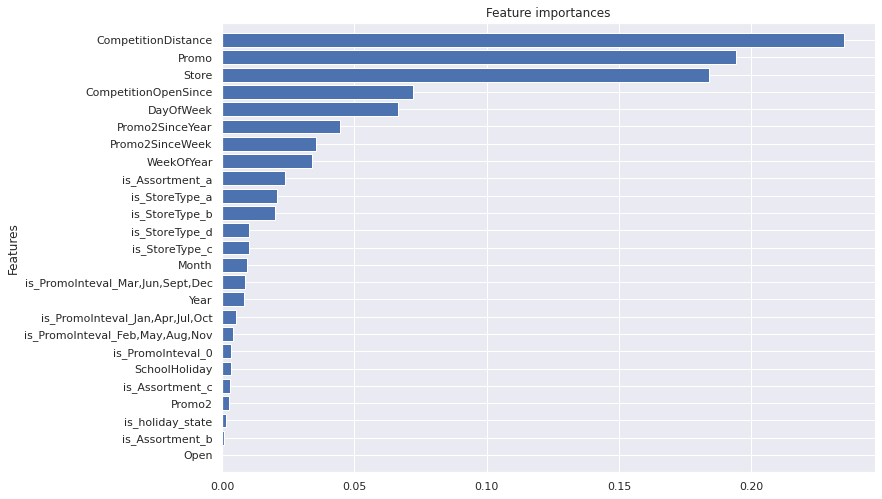

In [19]:

'''get the feature importance
regModel.regressor_ gives us the pipeline
regModel.regressor_.named_steps[randomForest] gives us the regressor''' 

importances = regModel.regressor_.named_steps['randomForest'].feature_importances_
std = np.std([regModel.regressor_.named_steps['randomForest'].feature_importances_
              for tree in regModel.regressor_.named_steps['randomForest'].estimators_], axis=0)

xPipe = regModel.regressor_.named_steps['multipleTrans'].returndf()

# rank the features
indices = np.argsort(importances)
featuresRanked = []
for f in range(xPipe.shape[1]):
    featuresRanked.append(xPipe.columns[indices[f]])

# plot the feature importance
plt.title("Feature importances")
plt.barh(range(xPipe.shape[1]), importances[indices], align="center")
plt.yticks(range(xPipe.shape[1]), featuresRanked)
plt.ylabel('Features')
plt.ylim([-1, xPipe.shape[1]])
plt.show()

The most important features are:
- Competition Distance : the stores furtherest away from competition will make more sales than stores that are surrounded by competitors
- Promo: As we saw earlier stores that had a promo (The first one) had more sales than the ones that didn't have any all
- Store: The Store itself represents a unique identificator for the algorithm to recognise which store has what attributes and indeed better accounts for the forecasting of those same stores in a future timeline.

### Serializing The Model

In [22]:
import pickle
import datetime

# get the current time and turn it into a string
now = datetime.datetime.now().strftime('%d-%m-%Y-%H-%M-%S-%f')[:-3]

# Save the model
filenameReg = 'regModel-' + now + '.pkl'
pickle.dump(regModel, open(filenameReg, 'wb'))

In [23]:
# predict on the testStore set
predictions = regModel.predict(dfTestStore)

# turn the predictions into a dataframe
dfPreds = pd.DataFrame({'Id': Id,
                        'Sales': predictions})

# save the predictions to csv for loading in the wep app
dfPreds.to_csv('testStore.csv', index=False)

2020-08-22 19:50:14,774 : INFO  : 
 the transform function has been called 

2020-08-22 19:50:14,774 : INFO  : 
 the transform function has been called 

2020-08-22 19:50:14,877 : INFO  : 
 creating the data Year, Month, Week of Year columns 

2020-08-22 19:50:14,877 : INFO  : 
 creating the data Year, Month, Week of Year columns 

/home/picklerick/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
2020-08-22 19:50:17,569 : INFO  : 
 running CompeSince 

2020-08-22 19:50:17,569 : INFO  : 
 running CompeSince 

2020-08-22 19:50:17,711 : INFO  : 
 running Set to Category 

2020-08-22 19:50:17,711 : INFO  : 
 running Set to Category 

2020-08-22 19:50:17,884 : INFO  : 
 Change state Holiday to 0 and 1 

2020-08-22 19:50

### Time Series Prediction

In [2]:
# load the data
dfTrain = pd.read_csv('train.csv', low_memory=False)
dfTest = pd.read_csv('test.csv', low_memory=False)
dfStore = pd.read_csv("store.csv", low_memory=False)

# dropping the zero sales and closed stores
dfTrain = dfTrain[(dfTrain.Open != 0) & (dfTrain.Sales != 0)]

In [3]:
def prophetData(df):
    logger.info('\n Making the prophet data')
    # sales for the store number 1 (StoreType C)
    sales = df[df.Store == 1].loc[:, ['Date', 'Sales']]

    # reverse to the order: from 2013 to 2015
    sales = sales.sort_index(ascending=False)

    # to datetime64
    sales['Date'] = pd.DatetimeIndex(sales['Date'])

    # from the prophet documentation every variables should have specific names
    sales = sales.rename(columns={'Date': 'ds', 'Sales': 'y'})

    # create a holidays dataframe
    state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b')
                     & (df.StateHoliday == 'c')].loc[:, 'Date'].values
    school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

    state = pd.DataFrame({'holiday': 'state_holiday', 'ds': pd.to_datetime(state_dates)})
    school = pd.DataFrame({'holiday': 'school_holiday', 'ds': pd.to_datetime(school_dates)})

    holidays = pd.concat((state, school))

    return sales, holidays

2020-08-22 15:16:28,146 : INFO  : 
 Making the prophet data
2020-08-22 15:16:37,750 : INFO  : Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2020-08-22 15:25:50,597 : DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0.
2020-08-22 15:25:50,603 : DEBUG : findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
2020-08-22 15:25:50,609 : DEBUG : findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
2020-08-22 15:25:50,613 : DEBUG : findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
2020-08-22 15:25:50,618 : DEBUG : findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
2020-08-22 15:25:50,623 : DEBUG : findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
2020-08-22 15:25:50,627 : DEBUG : findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldObliqu

2020-08-22 15:25:51,137 : DEBUG : findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335
2020-08-22 15:25:51,142 : DEBUG : findfont: score(<Font 'MathJax_Fraktur' (MathJax_Fraktur-Regular.otf) normal normal 400 normal>) = 10.05
2020-08-22 15:25:51,151 : DEBUG : findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
2020-08-22 15:25:51,157 : DEBUG : findfont: score(<Font 'MathJax_SansSerif' (MathJax_SansSerif-Bold.otf) normal normal 700 normal>) = 10.335
2020-08-22 15:25:51,166 : DEBUG : findfont: score(<Font 'MathJax_Script' (MathJax_Script-Regular.otf) normal normal 400 normal>) = 10.05
2020-08-22 15:25:51,174 : DEBUG : findfont: score(<Font 'MathJax_Caligraphic' (MathJax_Caligraphic-Bold.otf) normal normal 700 normal>) = 10.335
2020-08-22 15:25:51,182 : DEBUG : findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
2020-08-22 15:25:51,198 : DEBUG : findfont: sc

2020-08-22 15:25:52,678 : DEBUG : findfont: score(<Font 'FontAwesome' (FontAwesome.otf) normal normal 400 normal>) = 10.05
2020-08-22 15:25:52,682 : DEBUG : findfont: score(<Font 'MathJax_Vector' (MathJax_Vector-Regular.otf) normal normal 500 normal>) = 10.145
2020-08-22 15:25:52,692 : DEBUG : findfont: score(<Font 'MathJax_Size2' (MathJax_Size2-Regular.otf) normal normal 400 normal>) = 10.05
2020-08-22 15:25:52,696 : DEBUG : findfont: score(<Font 'MathJax_Vector-Bold' (MathJax_Vector-Bold.otf) normal normal 500 normal>) = 10.145
2020-08-22 15:25:52,704 : DEBUG : findfont: score(<Font 'MathJax_Main' (MathJax_Main-Italic.otf) italic normal 400 normal>) = 11.05
2020-08-22 15:25:52,708 : DEBUG : findfont: score(<Font 'MathJax_Math' (MathJax_Math-Regular.otf) normal normal 400 normal>) = 10.05
2020-08-22 15:25:52,712 : DEBUG : findfont: score(<Font 'MathJax_SansSerif' (MathJax_SansSerif-Regular.otf) normal normal 400 normal>) = 10.05
2020-08-22 15:25:52,716 : DEBUG : findfont: score(<Font 

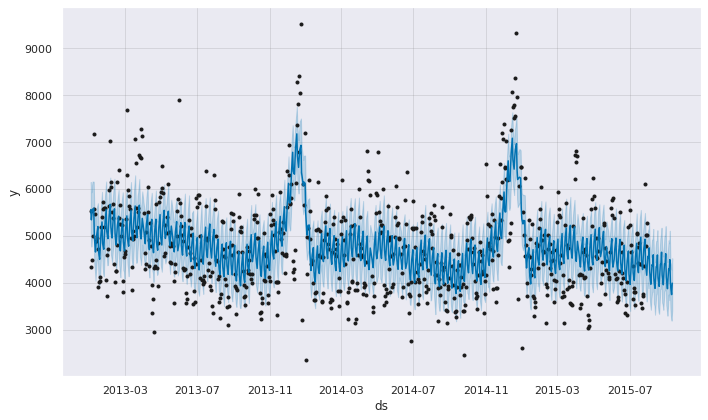

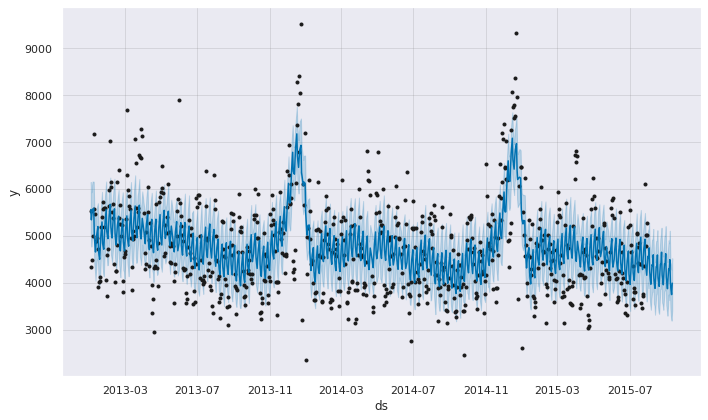

In [6]:
from fbprophet import Prophet
# Get the data for the model
sales, holidays = prophetData(dfTrain)

# training the prophet Model
pModel = Prophet(interval_width=0.5, holidays=holidays)
pModel.fit(sales)

# dataframe that extends into future 6 weeks
future_dates = pModel.make_future_dataframe(periods=6 * 7)

# prophet model predictions
forecast = pModel.predict(future_dates)

# rename prediction columns and isolate the predictions
fc = forecast[['ds', 'yhat']].rename(columns={'Date': 'ds', 'Forecast': 'yhat'})

In [7]:
# save the forecast values into a csv file
fc.to_csv('dateForecast.csv', index=False)

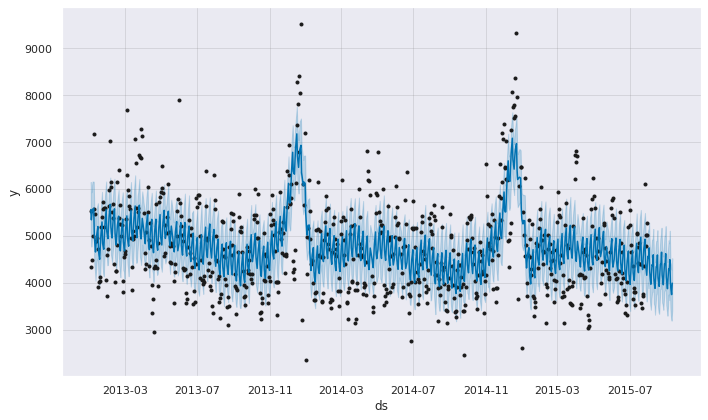

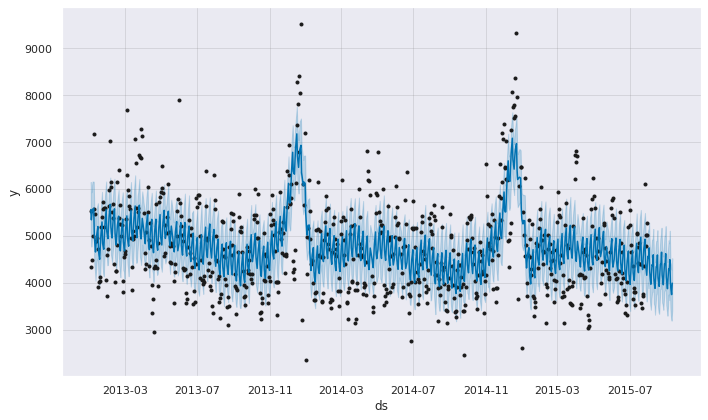

In [8]:
# plot predictions
pModel.plot(forecast)


As we see Prophet catches the trends and most of the time gets future values right.


### Prediction Analysis

In [9]:
# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
816,2015-09-05,4292.431718,3750.081820,4907.034150
817,2015-09-06,4269.107925,3631.064628,4840.589701
818,2015-09-07,4490.528903,3927.229041,5108.986392
819,2015-09-08,3982.051379,3424.926031,4448.219757
820,2015-09-09,3849.142650,3254.554557,4383.653151
821,2015-09-10,3746.291698,3190.122556,4277.545465
822,2015-09-11,3990.483719,3411.559572,4522.142556


The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

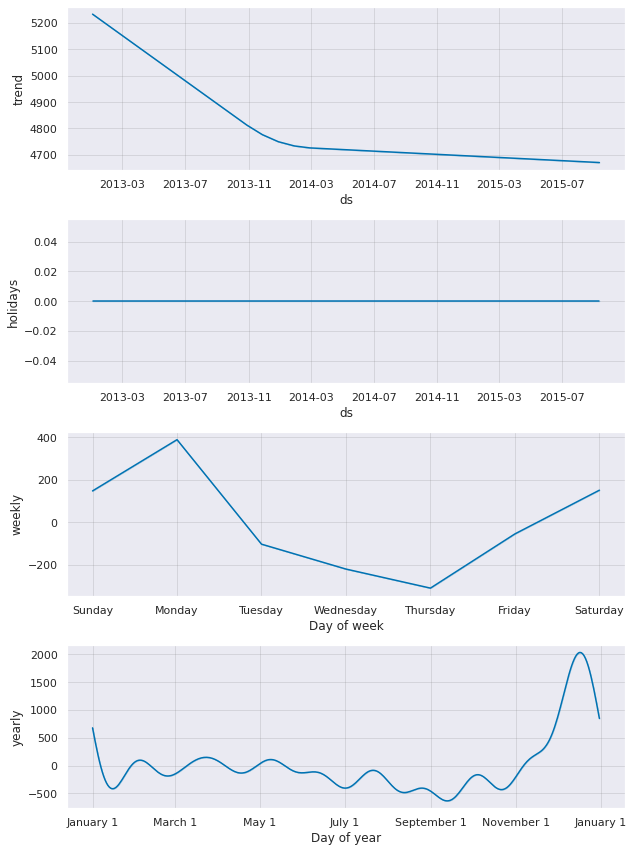

In [10]:
pModel.plot_components(forecast);

The first plot shows that the monthly sales of store number 1 has been linearly decreasing over time and the second shows the holiays gaps included in the model. The third plot highlights the fact that the weekly volume of last week sales peaks towards the Monday of the next week, while the forth plot shows that the most buzy season occurs during the Christmas holidays.

In [25]:
pModel.stan_backend.logger = None

# create filename
filenamePro = 'pModel-' + now + '.pkl'

# Save the model
pickle.dump(pModel, open(filenamePro, 'wb'))